Importing libraries

In [3]:
import pandas as pd
import keras
import sklearn.metrics as metrics
import numpy as np
import keras.backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from time import time

from keras import callbacks
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
# from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
import os


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np


from sklearn.neighbors import KNeighborsClassifier

from  sklearn.naive_bayes import GaussianNB
from  sklearn.naive_bayes import MultinomialNB

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, v_measure_score, calinski_harabasz_score, r2_score, roc_curve, plot_roc_curve, silhouette_score
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.metrics import auc,roc_curve

from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import kl_divergence
from tensorflow import convert_to_tensor

import warnings
warnings.filterwarnings('ignore')



Fully connected auto-encoder model

In [4]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

In [5]:

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Deep Embedded Clustering (DEC) is a method that simultaneously learns feature representations and cluster assignments using deep neural networks. DEC learns a mapping from the data space to a lower-dimensional feature space in which it iteratively
optimizes a clustering objective.

In [6]:
class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if int(epochs/10) != 0 and epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    # km = KMedoids(n_clusters=len(np.unique(self.y)), metric='euclidean', method='alternate', init='heuristic', max_iter=100, random_state=None)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: %ds' % round(time() - t0))
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = int(x.shape[0] / batch_size) * 5  # 5 epochs
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        # kmeans = KMedoids(n_clusters=self.n_clusters, metric='euclidean', method='alternate', init='heuristic', max_iter=100, random_state=None)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, y_pred), 5)
                    nmi = np.round(metrics.nmi(y, y_pred), 5)
                    ari = np.round(metrics.ari(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # # save intermediate model
            # if ite % save_interval == 0:
            #     print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
            #     self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred


Loading the stratified dataset

In [7]:
def LoadData():
    data = pd.read_csv("./results/som/propagated_mut.csv", delimiter=",")
    # data = data.set_index("patient_id")
   
    return data

def renorm(network):    
    degree = np.sum(network,axis=0)
    return network*1.0/degree  
    
def run_diffusion_PPR(PPR,mutation_profile,normalize_mutations=False):

    if normalize_mutations:
        mutation_profile = renorm(mutation_profile.T).T

    Q = np.dot(mutation_profile,PPR)

    return Q


In [8]:
df = LoadData()
data = np.array(df.drop('patient_id',axis=1))


In [9]:
init = 'glorot_uniform'
pretrain_optimizer = 'adam'
batch_size = 100
maxiter = 2e4
tol = 0.001
save_dir = 'results/DEC'

In [10]:
path = save_dir

# Check whether the specified path exists or not
isExist = os.path.exists(path)

if not isExist:
  
  # Create a new directory because it does not exist 
  os.makedirs(path)
  print("The new directory is created!")

Defining the model. To change the number of clusters change the n_clusters parameter. In the paper results are discussed for k = 5 and k = 10.

In [11]:
dec = DEC(dims=[data.shape[-1], 500, 200], n_clusters=5)

In [12]:
dec.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 84)]              0         
                                                                 
 encoder_0 (Dense)           (None, 500)               42500     
                                                                 
 encoder_1 (Dense)           (None, 200)               100200    
                                                                 
 clustering (ClusteringLayer  (None, 5)                1000      
 )                                                               
                                                                 
Total params: 143,700
Trainable params: 143,700
Non-trainable params: 0
_________________________________________________________________


Clustering and saving the model

In [13]:
update_interval = 100

dec.compile(optimizer=SGD(0.1, 0.3), loss='kld')

y_pred = dec.fit(data,  tol=tol, maxiter=maxiter, batch_size=batch_size,
                 update_interval=update_interval, save_dir=save_dir)


Update interval 100
Save interval 90
Initializing cluster centers with k-means.
delta_label  0.000555247084952804 < tol  0.001
Reached tolerance threshold. Stopping training.
saving model to: results/DEC/DEC_model_final.h5


Performance measures: Silhouette and Davies Bouldin Scores

In [ ]:
print(silhouette_score(data,y_pred))
print(davies_bouldin_score(data,y_pred))

saving cluster assignments to file.

In [15]:
preds = pd.DataFrame({"patient_id" : df.patient_id, "cluster" : y_pred})

In [16]:
preds.to_csv('./results/DEC/dec_cluster_assignments_5.csv', index=False) 

PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA(3)
 
#Transform the data
df_pca = pca.fit_transform(data)
 
df_pca

array([[-2.37015679,  4.89546069, -2.70982118],
       [-1.37078366, -3.1872629 , -0.76503733],
       [ 1.38723357,  3.66738323, -7.44878383],
       ...,
       [-4.65256086,  2.34220391, -0.49927309],
       [-1.25307467, -2.60337335,  3.4297377 ],
       [-6.54610967, -9.62465373, -1.3850364 ]])

In [23]:
update_interval = 100

dec.compile(optimizer=SGD(0.1, 0.3), loss='kld')

y_pred = dec.fit(data,  tol=tol, maxiter=maxiter, batch_size=batch_size,
                 update_interval=update_interval, save_dir="results/DEC/dec_pca")


Update interval 100
Save interval 90
Initializing cluster centers with k-means.
delta_label  0.000555247084952804 < tol  0.001
Reached tolerance threshold. Stopping training.
saving model to: results/DEC/dec_pca/DEC_model_final.h5


In [24]:
y_pred

array([3, 0, 3, ..., 2, 4, 4], dtype=int64)

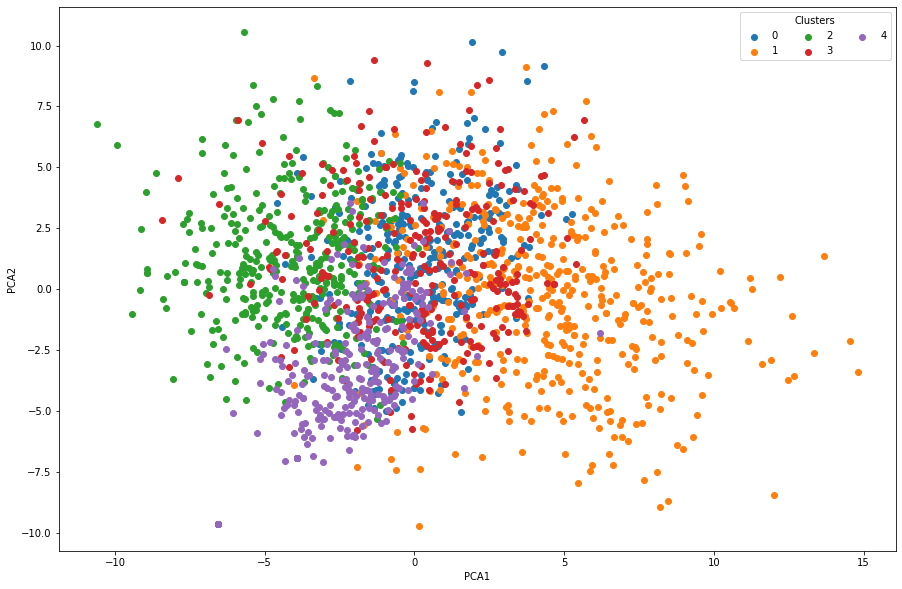

In [72]:
#Getting unique labels
 
u_labels = np.unique(y_pred)
 
#plotting the results:
plt.figure(figsize=(15,10))
for i in u_labels:
    plt.scatter(df_pca[y_pred == i, 0] , df_pca[y_pred == i , 1] , label = i)
plt.legend(title = "Clusters", ncol = 3)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

In [28]:
df_pca

array([[-2.37015679,  4.89546069, -2.70982118],
       [-1.37078366, -3.1872629 , -0.76503733],
       [ 1.38723357,  3.66738323, -7.44878383],
       ...,
       [-4.65256086,  2.34220391, -0.49927309],
       [-1.25307467, -2.60337335,  3.4297377 ],
       [-6.54610967, -9.62465373, -1.3850364 ]])

In [33]:
result

,PCA0,PCA1,PCA2
0,-2.370157,4.895461,-2.709821
1,-1.370784,-3.187263,-0.765037
2,1.387234,3.667383,-7.448784
3,-3.445595,1.337710,-1.621466
4,-3.290869,0.949915,4.051454
...,...,...,...
1796,-4.542615,-3.881879,0.272094
1797,0.314671,-1.411263,-0.524004
1798,-4.652561,2.342204,-0.499273
1799,-1.253075,-2.603373,3.429738


<Figure size 10000x10000 with 0 Axes>

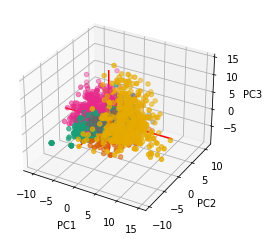

In [69]:
plt.figure(figsize=(100, 100), dpi=100)
# Store results of PCA in a data frame
result=pd.DataFrame(df_pca, columns=['PCA%i' % i for i in range(3)])
my_color=y_pred
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=my_color, cmap = "Dark2_r")
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()
